In [1]:
import simpy
import random
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import LogNorm
from time import time

In [2]:
class FiFoServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.Resource(env, capacity=num_servers)


class SJFServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.PriorityResource(env, capacity=num_servers)


def task(env, servers, processing_time, waiting_times):
    """
    Simulates the arrival and processing of a task at a server.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - servers (Servers): An object representing the server(s) and related attributes.
    - processing_time (float): The time it takes to process the task at the server.
    - waiting_times (list): A list to store the waiting time of each task.

    Description:
    - A task arrives at the server, requesting access.
    - Once there is availability at the server, the task is initiated.
    - The task is processed for a specified duration (processing_time).
    - The waiting time is recorded for analysis.
    """ 

    # A task arrives at the server
    start_time = env.now    

    # Request task to server
    with servers.server.request() as req:

        # Once there is availability at the server, initiate task
        yield req
        end_time = env.now

        yield env.timeout(processing_time)
        waiting_times.append(end_time - start_time)


def get_confidence(data, p=0.95):
    """
    Calculate the mean and confidence interval of a dataset for a given confidence level.

    Parameters:
    - data (array-like): Input data.
    - p (float, optional): Confidence level (default is 0.95).

    Returns:
    tuple: A tuple containing the mean and the confidence interval.
    """

    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n - 1)
    sigma = np.std(data)
    confidence = (lamb * sigma / np.sqrt(n))
    return mean, confidence

In [3]:
def task_generator_markov(env, servers, N, lambda_, waiting_times):
    """
    Generates and processes N tasks in a Markovian task arrival- and processing setting.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - servers (Servers): An object representing the server(s) and related attributes.
    - N (int): The number of tasks to generate and process.
    - lambda_ (float): The arrival rate parameter for the Poisson process.
    - waiting_times (list): A list to store the waiting time of each task.

    Description:
    - Generates and processes N tasks in a Markovian task arrival setting.
    - Each task is created and processed by the `task` function.
    - The processing time is determined by the exponential distribution with rate `servers.mu`.
    - The inter-arrival time between tasks is determined by the exponential distribution with rate `lambda_`.
    """ 

    # Generate N tasks
    for _ in range(N):
        
        # Calculate time at server from exponential distribution
        processing_time = random.expovariate(servers.mu)

        # Create task
        env.process(task(env, servers, processing_time, waiting_times))

        # Calculate time until next task from exponential distribution
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)


def task_generator_long_tail(env, servers, N, lambda_, waiting_times):
    """
    Generates and processes N tasks in a scenario with a long-tailed processing time distribution.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - servers (Servers): An object representing the server(s) and related attributes.
    - N (int): The total number of tasks to generate and process.
    - lambda_ (float): The arrival rate parameter for the Poisson process.
    - waiting_times (list): A list to store the waiting time of each task.

    Description:
    - Generates and processes N tasks with a processing time distribution that has a long tail.
    - 75% of the tasks have a processing time following an exponential distribution with rate `servers.mu`.
    - The remaining 25% of tasks have a processing time reduced by 60% compared to `servers.mu`.
    - Each task is created and processed by the `task` function.
    - The inter-arrival time between tasks is determined by the exponential distribution with rate `lambda_`.
    """ 

    # Generate 75% of N tasks with a processing time of mu and remaining 25% with mu reduced by 60%.
    for _ in range(N):
        u = np.random.rand()
        if u <= 0.75:
            processing_time = random.expovariate(servers.mu)
        else:
            processing_time = random.expovariate(0.4 * servers.mu)

        # Create task
        env.process(task(env, servers, processing_time, waiting_times))

        # Calculate time until next task from exponential distribution
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)


def task_generator_deterministic(env, servers, N, lambda_, waiting_times):
    """
    Generates and processes N tasks with a deterministic processing time.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - servers (Servers): An object representing the server(s) and related attributes.
    - N (int): The total number of tasks to generate and process.
    - lambda_ (float): The arrival rate parameter for the Poisson process.
    - waiting_times (list): A list to store the waiting time of each task.

    Description:
    - Generates and processes N tasks with a fixed, deterministic processing time.
    - Each task has a processing time equal to the inverse of the server processing rate (`1/servers.mu`).
    - Each task is created and processed by the `task` function.
    - The inter-arrival time between tasks is determined by the exponential distribution with rate `lambda_`.
    """

    for _ in range(N):
        processing_time = 1/servers.mu

        # Create task
        env.process(task( env, servers, processing_time, waiting_times))

        # Calculate time until next task from exponential distribution
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

In [4]:
def run_simulation(num_servers, mu, lambda_, N, scheduler, mode):
    """
    Run a simulation with specified parameters and scheduling policy.

    Parameters:
    - num_servers (int): The number of servers in the system.
    - mu (float): The processing rate of each server.
    - lambda_ (float): The arrival rate of tasks.
    - N (int): The total number of tasks to simulate.
    - scheduler (str): The scheduling policy ('fifo' for First-in First-out, 'sjf' for Shortest Job First).
    - mode (str): The mode of task generation ('deter' for deterministic, 'long tail' for long-tailed distribution, 'Markov' for Markovian).

    Returns:
    - float: The mean waiting time of tasks in the simulation.

    Description:
    - Initializes a simulation environment with specified parameters.
    - Chooses the scheduling policy based on the provided 'scheduler' argument.
    - Generates and processes tasks according to the specified mode of task generation.
    - Returns the mean waiting time of tasks in the simulation.
    """

    env = simpy.Environment()

    # Use either First-in First-out or Shortest Job First scheduling
    if scheduler.lower() == 'fifo':
        servers = FiFoServers(env, mu, num_servers)
    elif scheduler.lower() == 'sjf':
        servers = SJFServers(env, mu, num_servers)

    waiting_times = []

    # Generate tasks
    if mode == 'deter':
        env.process(task_generator_deterministic(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'long tail':
        env.process(task_generator_long_tail(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'Markov':
        env.process(task_generator_markov(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()

    return np.mean(waiting_times)

In [5]:
def generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n):
    """
    Generates data for the average waiting times with different servers and different system loads.

    Parameters:
    - lambda_ (float): The arrival rate parameter for the Poisson process.
    - mus (list): List of processing rates for servers.
    - N (int): The total number of tasks to simulate in each run.
    - num_servers_list (list): List of different numbers of servers to evaluate.
    - scheduler (str): The scheduling policy ('fifo' for First-in First-out, 'sjf' for Shortest Job First).
    - mode (str): The mode of task generation ('deter' for deterministic, 'long tail' for long-tailed distribution, 'Markov' for Markovian).
    - n (int): The number of simulations to run for each configuration.

    Returns:
    - dict: A dictionary containing data for waiting times, confidence intervals, and corresponding parameters.

    Description:
    - Generates data for the average waiting times with different numbers of servers and varying system loads.
    - Runs simulations for different configurations, averaging results over multiple simulations.
    - Uses a specified scheduling policy and task generation mode.
    - Calculates mean waiting times and confidence intervals using the `get_confidence` function.
    """
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}

    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = []

            # Run simulation multiple times
            for _ in range(n):
                mean_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, mode)
                waiting_times_for_simulations.append(mean_waitingtime)

            # Calculate mean and confidence interval using the get_confidence function
            mean, confidence = get_confidence(waiting_times_for_simulations)
            waitingtimes.append(mean)
            confidences.append(confidence)

        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences}

    return data


def generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, mode, std_min):
    """
    Generate data for average waiting times with different numbers of servers and varying system loads.
    Perform simulations for each configuration until the standard deviation is less than std_min.

    Parameters:
    - lambda_ (float): The arrival rate parameter for the Poisson process.
    - mus (list): List of processing rates for servers.
    - N (int): The total number of tasks to simulate in each run.
    - num_servers_list (list): List of different numbers of servers to evaluate.
    - scheduler (str): The scheduling policy ('fifo' for First-in First-out, 'sjf' for Shortest Job First).
    - mode (str): The mode of task generation ('deter' for deterministic, 'long tail' for long-tailed distribution, 'Markov' for Markovian).
    - std_min (float): The minimum desired standard deviation to achieve for waiting times.

    Returns:
    - dict: A dictionary containing data for waiting times, confidence intervals, and corresponding parameters.

    Description:
    - Generates data for the average waiting times with different numbers of servers and varying system loads.
    - Runs simulations for each configuration until the standard deviation of waiting times is less than std_min.
    - Calculates mean waiting times and confidence intervals using the `get_confidence` function.
    - Records the number of simulations performed for each configuration.

    """
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}
    
    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []
        n_simulations = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = np.array([])
            n = 0

            # Run simulations until desired standard deviation is reached
            while not ((n > 50 and std/np.sqrt(n) < std_min) or n > 800):
                mean_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, mode)
                waiting_times_for_simulations = np.append(waiting_times_for_simulations, mean_waitingtime)
                std = np.std(waiting_times_for_simulations)
                n += 1

            # Calculate mean and confidence interval using the get_confidence function
            mean, confidence = get_confidence(waiting_times_for_simulations)
            waitingtimes.append(mean)
            confidences.append(confidence)
            n_simulations.append(n)
        
        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations}
    return data


def plot_waitingtimes(data, ax, xticks=None, yticks=None, xlim=None, ylim=None):
    """
    Plots the average waiting times with different servers and different system loads.

    Parameters:
    - data (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters.
    - ax (matplotlib.axes._axes.Axes): The matplotlib axes on which to plot the data.
    - xticks (list or None): List of x-axis tick locations. If None, ticks are automatically determined.
    - yticks (list or None): List of y-axis tick locations. If None, ticks are automatically determined.
    - xlim (tuple or None): Tuple specifying the x-axis limits (min, max). If None, limits are automatically determined.
    - ylim (tuple or None): Tuple specifying the y-axis limits (min, max). If None, limits are automatically determined.

    Description:
    - Plots average waiting times with different numbers of servers and varying system loads.
    - Displays the mean waiting times as lines and confidence intervals as shaded regions around the lines.
    - The x-axis represents the system load (rho), and the y-axis represents the average waiting time.
    - Legend includes the number of servers for each line.
    """
    
    # Loop over number of servers
    for num_servers, values in data.items():

        # Extract data
        x = values['x']
        waitingtimes = values['waitingtimes']
        confidence_waitingtime = np.array(values['confidences'])

        # Plot data
        ax.plot(x, waitingtimes, label=f'c = {num_servers}')
        ax.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

    # Set layout
    ax.set_xlabel('$\\rho$')
    ax.set_ylabel("Average waiting time")
    ax.legend()

    if xticks:
        ax.set_xticks(xticks)
    if yticks:
        ax.set_yticks(yticks)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)


def plot_nsimulations(data,axs):
    """
    Plot the number of simulations required to achieve a stable confidence interval.
    
    Parameters:
    - data (dict): A dictionary containing data for the number of simulations and corresponding parameters.
    - axs (numpy.ndarray): A NumPy array of matplotlib axes on which to plot the data.

    Description:
    - Plots the number of simulations needed to achieve the same confidence interval with different numbers of servers and varying system loads.
    - The x-axis represents the system load (rho), and the y-axis represents the number of simulations.
    - Each line corresponds to a different number of servers.
    - Legend includes the number of servers for each line.

    """

    # Loop over number of servers
    for num_servers, values in data.items():

        # Extract data
        x = values['x']
        n_simulations = values['n_simulations']

        axs.plot(x, n_simulations, label=f'Number of servers = {num_servers}')

    axs.set_xlabel("System load")
    axs.set_ylabel("Number of simulations")
    axs.legend()

In [6]:
def welch_test(data1, data2):
    """
    Perform Welch's t-test to compare waiting times between two datasets with different numbers of servers.

    Parameters:
    - data1 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 1).
    - data2 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 2).

    Description:
    - Compares waiting times between two datasets with different numbers of servers using Welch's t-test.
    - Welch's t-test is applied for each number of servers separately.
    - The null hypothesis is that there is no difference in average waiting times between the two datasets.
    - The alternative hypothesis is that there is a significant difference.
    - Prints the t-statistic, p-value, and whether the null hypothesis is rejected at a 0.05 significance level.
    """
    
    num_servers_list = [1, 2, 4]

    # Loop over number of servers
    for num_servers in num_servers_list:

        # Extract data
        waiting_times1 = data1[num_servers]['waitingtimes']
        waiting_times2 = data2[num_servers]['waitingtimes']
        confidence_p = 0.05

        # Perform the 2 sample t test
        t_test_2_samples = stats.ttest_ind(waiting_times1, waiting_times2, equal_var=False)
        passed_null_hypothesis = confidence_p > t_test_2_samples.pvalue

        print(f"Number of servers is {num_servers}")
        print(t_test_2_samples)
        print(passed_null_hypothesis)

        
def correlation(data1, data2, data3):
    """
    Compute the correlation matrix between waiting times for different task generation methods and numbers of servers.

    Parameters:
    - data1 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 1).
    - data2 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 2).
    - data3 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 3).

    Description:
    - Computes the correlation matrix between waiting times for different task generation methods (Markov, Long tail, Deterministic)
      and different numbers of servers.
    - Each row/column in the matrix corresponds to a task generation method, and the values represent correlations.
    - Prints the correlation matrix for each number of servers.
    """

    num_servers_list = [1, 2, 4]

    # Loop over number of servers
    for num_servers in num_servers_list:

        # Extract data
        markov = data1[num_servers]['waitingtimes']
        long_tail = data2[num_servers]['waitingtimes']
        deter = data3[num_servers]['waitingtimes']

        # Calculate statistics
        data = np.array([markov, long_tail, deter])
        covariance_matrix = np.corrcoef(data)

        print(f"Correlation for {num_servers} servers")
        df = pd.DataFrame(covariance_matrix, columns=['Markov', 'Long tail', 'Deter'], index=['Markov', 'Long tail', 'Deter'])
        print(df)
        print("\n")


def regression_test(data1, data2):
    """
    Check if two datasets have a linear relationship.

    Parameters:
    - data1 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 1).
    - data2 (dict): A dictionary containing data for waiting times, confidence intervals, and corresponding parameters (Dataset 2).

    Description:
    - Checks if there's a linear relationship between waiting times for two datasets with different numbers of servers (M/D/n and M/M/n).
    - Uses a linear regression test with a significance level of 0.05.
    - Prints the results for each number of servers, including the slope, p-value, and whether the null hypothesis is rejected.
    """

    num_servers_list = [1, 2, 4]
    confidence = 0.05

    # Loop over number of servers
    for num_servers in num_servers_list:

        # Extract data
        data1_waiting_times = data1[num_servers]['waitingtimes']
        data2_waiting_times = data2[num_servers]['waitingtimes']

        # Calculate statistica
        slope, _, _, p_value, _ = stats.linregress(data1_waiting_times, data2_waiting_times)

        # Print results
        if p_value < confidence:
            print(f"For {num_servers} servers, we reject the null Hypothesis with a  slope of {slope} and a pvalue of {p_value}")
        else:
            print(f"For {num_servers} servers we do not reject the null Hypothesis with a slope of {slope} and a pvalue of {p_value}")


def error_comparison(data1, data2, num_servers_list):
    """
    Compare errors between two datasets for waiting times and the number of simulations.

    Parameters:
    - data1 (dict): A dictionary containing data for waiting times, confidence intervals, and the number of simulations (Dataset 1).
    - data2 (dict): A dictionary containing data for waiting times, confidence intervals, and the number of simulations (Dataset 2).
    - num_servers_list (list): List of different numbers of servers to evaluate.

    Returns:
    - tuple: A tuple containing two dictionaries.
      - The first dictionary represents the mean errors in waiting times for each number of servers.
      - The second dictionary represents the mean errors in the number of simulations for each number of servers.

    Description:
    - Compares errors between two datasets for waiting times and the number of simulations with different numbers of servers.
    - Calculates mean errors as the mean of the differences between corresponding values in the two datasets.
    - Returns two dictionaries, one for waiting times and one for the number of simulations, indexed by the number of servers.
    """

    error_waitingtimes = {}
    error_n_simulations = {}

    # Loop over number of servers
    for num_servers in num_servers_list:

        # Calculate errors
        error_waitingtimes[num_servers] = np.mean(np.array(data1[num_servers]['waitingtimes']) - np.array(data2[num_servers]['waitingtimes']))
        error_n_simulations[num_servers] = np.mean(np.array(data1[num_servers]['n_simulations']) - np.array(data2[num_servers]['n_simulations']))

    return error_waitingtimes, error_n_simulations

In [ ]:
# Parameters
lambda_ = 0.015
rho = 0.9
Ns = [200, 500, 1000, 2000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000]
mus = np.array([lambda_ / rho])

ns = np.arange(5, 15)
num_servers = 1

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

all_data = []
all_times = []
for N in Ns:
    print(f"Currently at N={N}")
    data = []
    times = []
    for n in ns:
        confidence = 0
        for i in range(3):
            start = time()
            values = generate_waitingtimes(lambda_, mus, N, [num_servers], scheduler, mode, n)[num_servers]
            end = time()

            confidence += values['confidences'][0] / 3
        times.append(end - start)
        data.append(confidence)

    all_data.append(data)
    all_times.append(times)

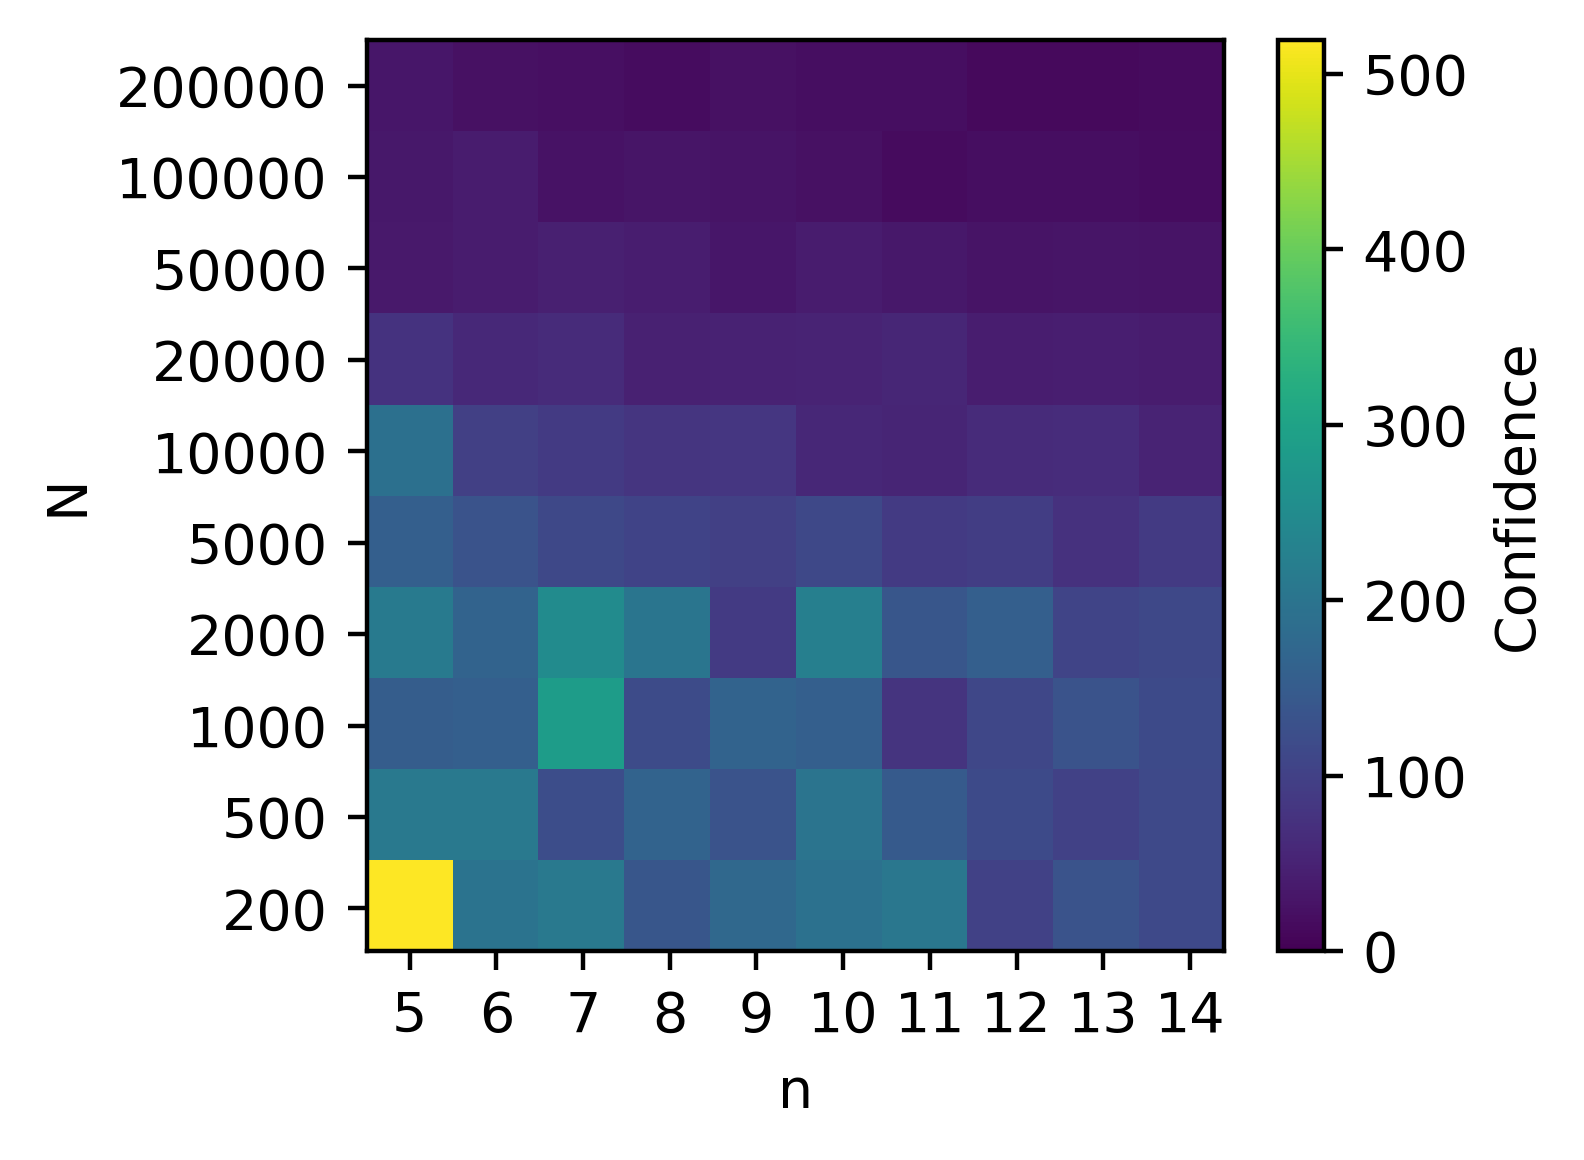

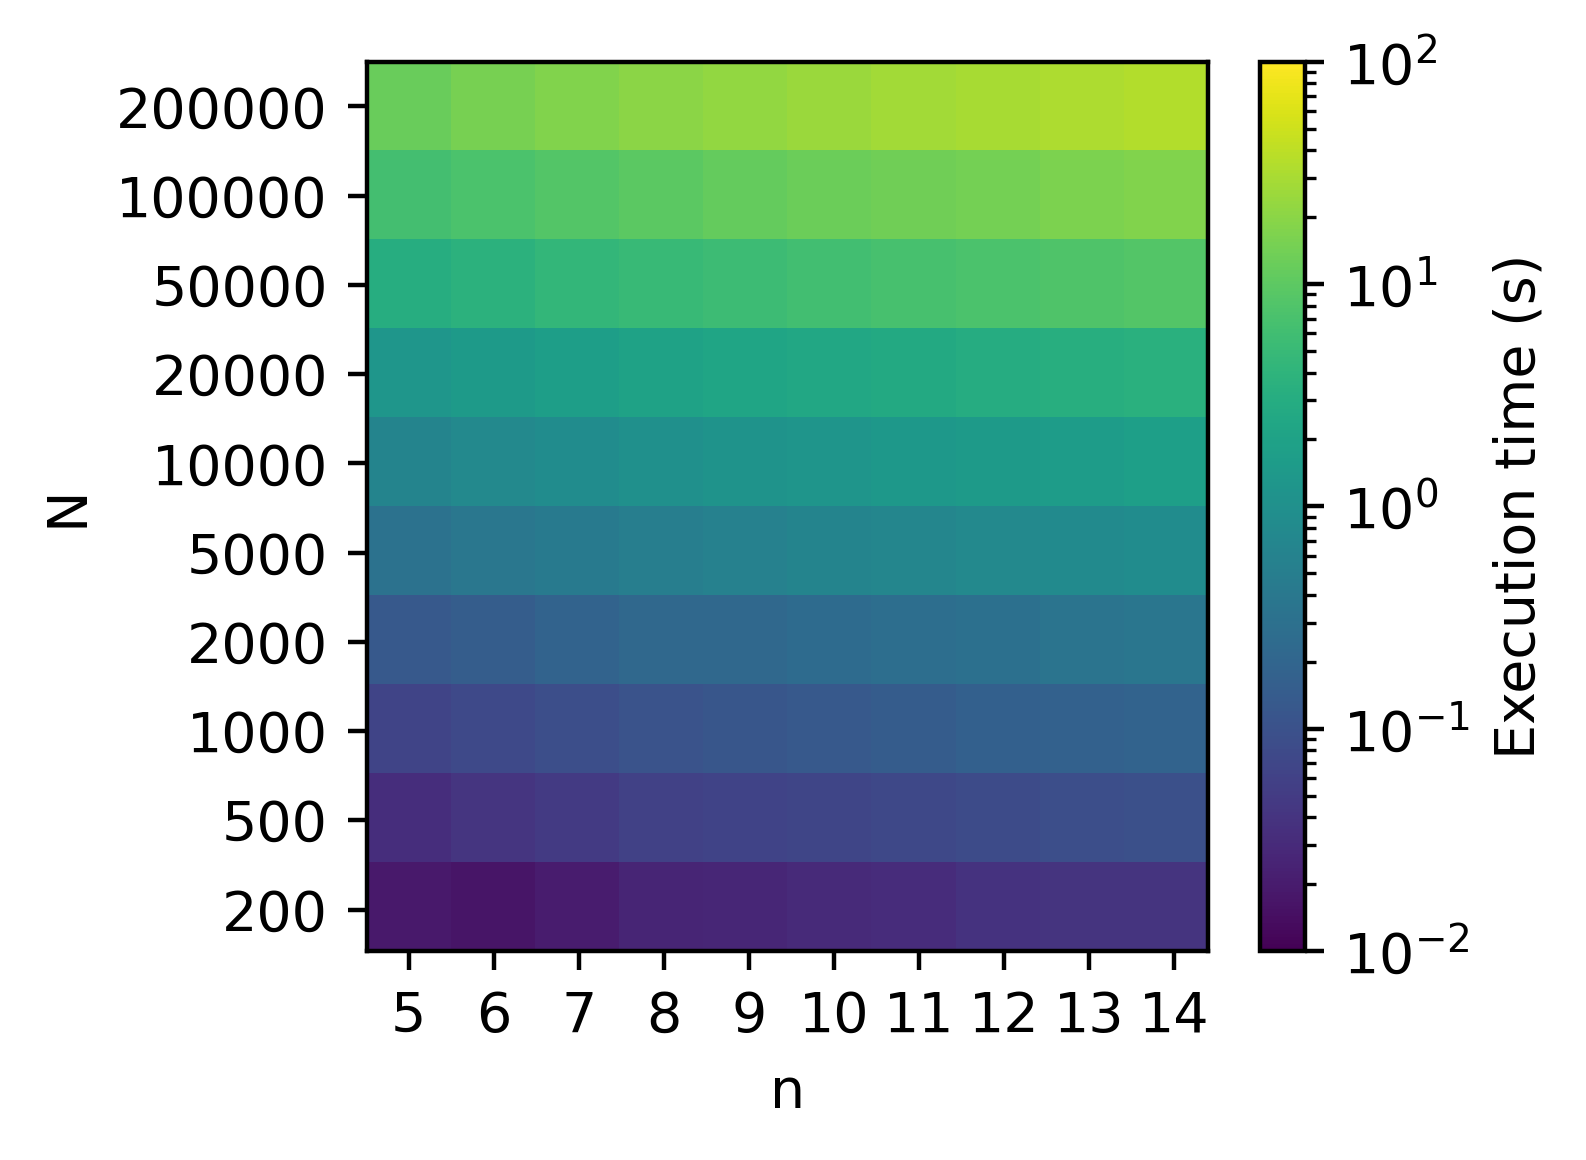

In [ ]:
plt.figure(figsize=(4, 3), dpi=400)
plt.imshow(all_data, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', vmin=0)
colorbar = plt.colorbar(label=f'Confidence')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(10_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_waitingime.png')
plt.show()

plt.figure(figsize=(4, 3), dpi=400)
plt.imshow(all_times, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', norm=LogNorm(0.01, 100))
colorbar = plt.colorbar(label=f'Execution time (s)')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(10_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_time.png')
plt.show()

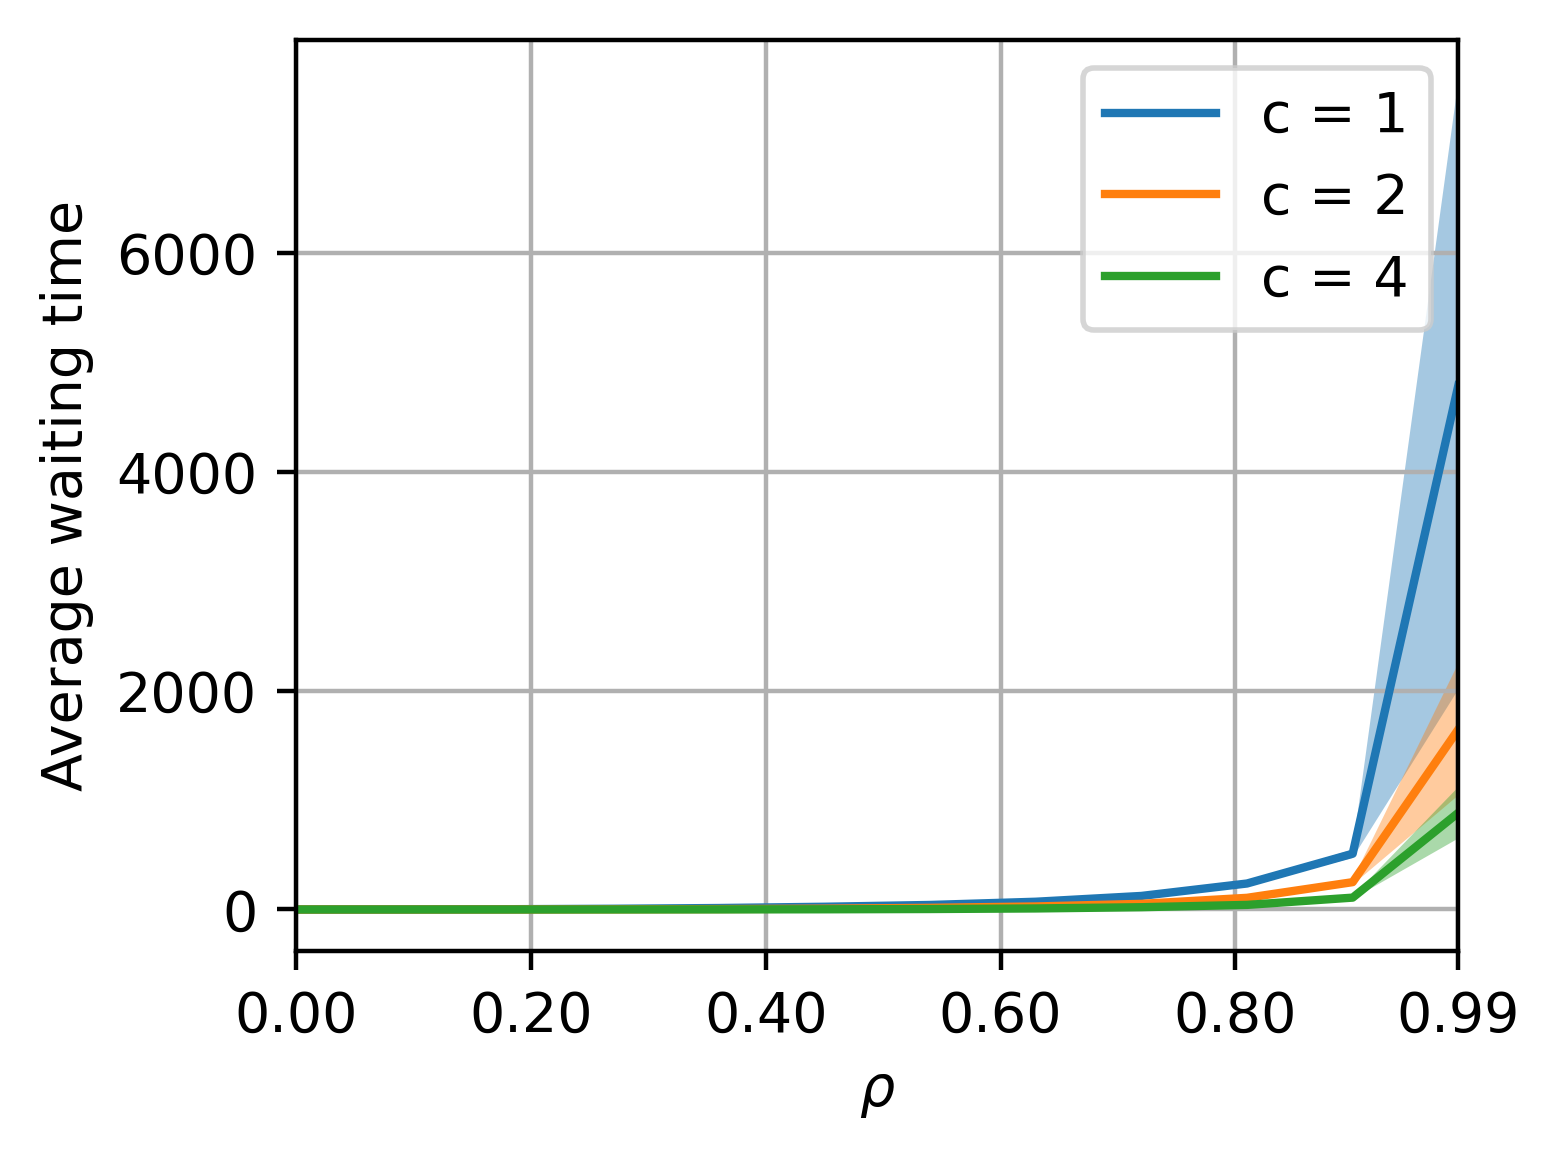

In [8]:
# Parameters
lambda_ = 0.015
N = 20_000
num_servers_list = [1, 2, 4]
scheduler = 'fifo'
mode = 'Markov'

# Generate array of values for mu
rho_min, rho_max = 0.0, 0.99
rhos_step = 0.09

rhos = np.linspace(rho_min, rho_max, 12)
mus = lambda_ / rhos

# Number of runs
n = 10

# Generate FIFO data
fig, ax = plt.subplots(figsize=(4, 3), dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

# Set plotting parameters
xticks = [rhos[0], 0.2, 0.4, 0.6, 0.8, rhos[-1]]
xlim = [rhos[0], rhos[-1]]
plot_waitingtimes(data, ax, xticks=xticks, xlim=xlim)

ax.grid(True)
fig.tight_layout()
fig.savefig('Q2_MMc_FIFO.png')

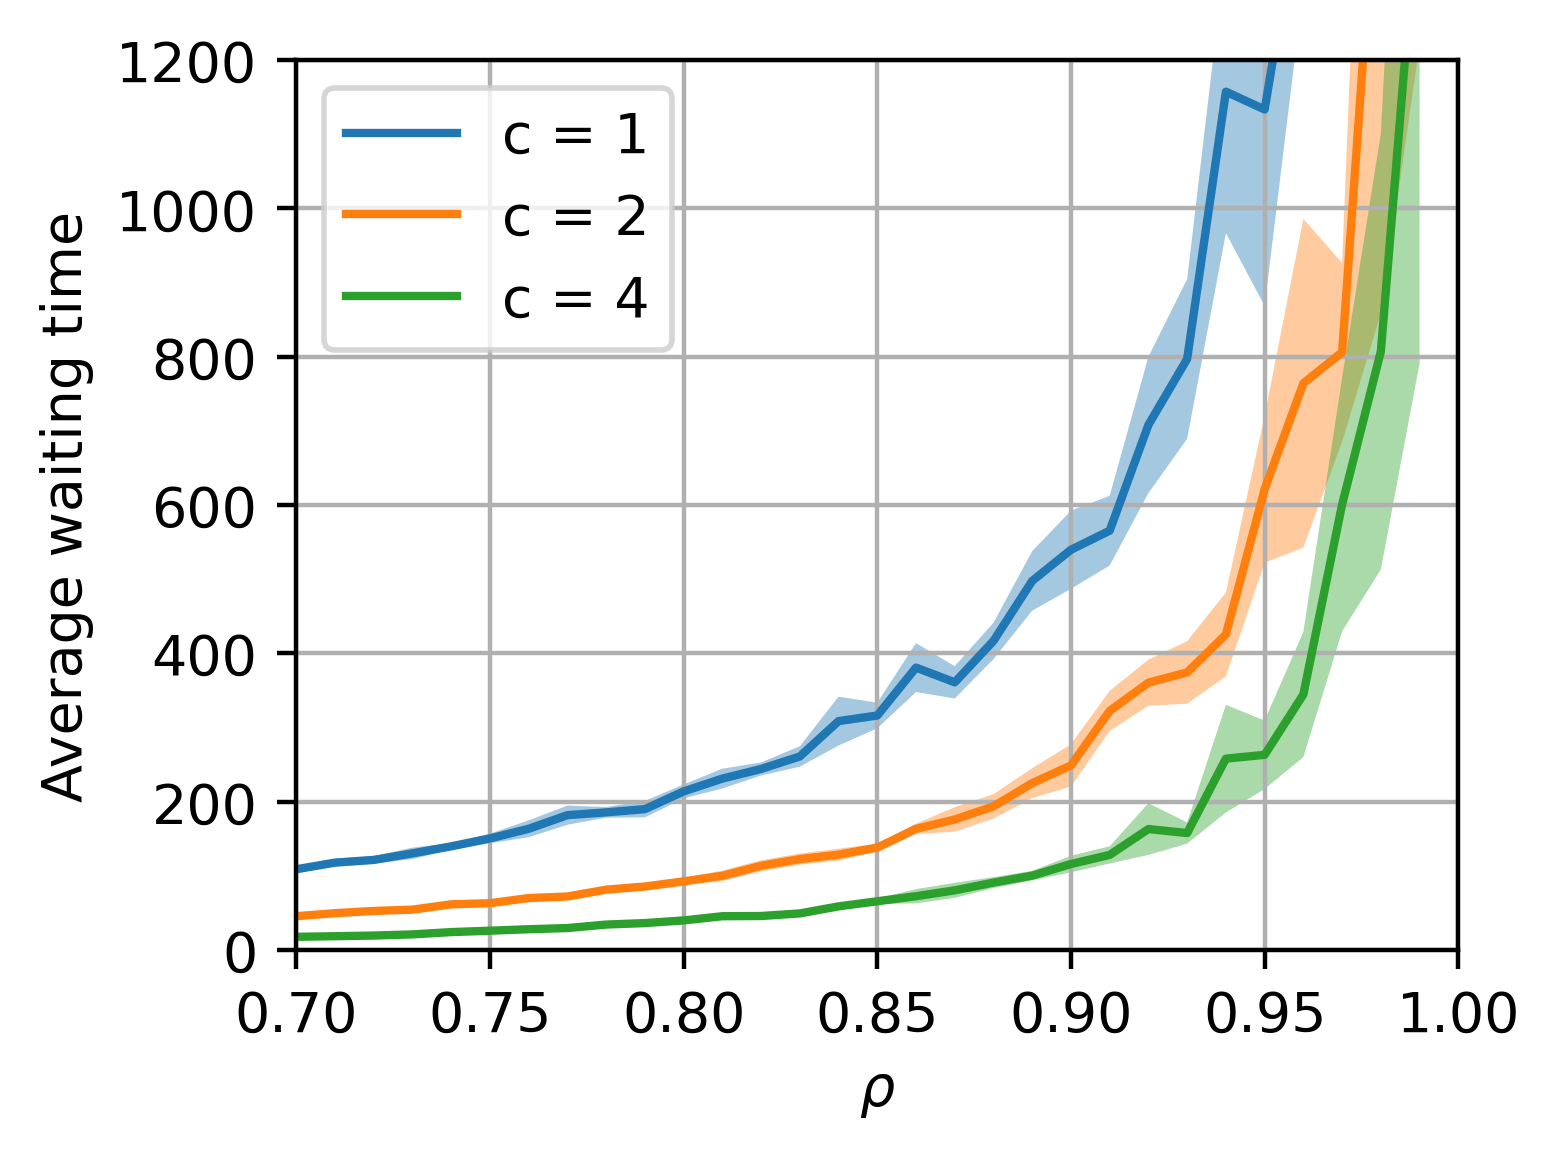

In [9]:
# Parameters
lambda_ = 0.015
N = 20_000
num_servers_list = [1, 2, 4]
scheduler = 'fifo'
mode = 'Markov'

# Generate array of values for mu
rho_min, rho_max = 0.7, 0.99
rhos_step = 0.01

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs
n = 10

# Generate FIFO data with a smaller range and higher density
fig, ax = plt.subplots(figsize=(4, 3), dpi=400)
data_zoomed = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

# Set plotting parameters
xticks = [rhos[0], 0.75, 0.8, 0.85, 0.9, 0.95, 1]
xlim = [rhos[0], 1]
ylim = [0, 1200]
plot_waitingtimes(data_zoomed, ax, xticks=xticks, xlim=xlim, ylim=ylim)

ax.grid(True)
fig.tight_layout()
fig.savefig('Q2_MMc_FIFO_zoomed.png')

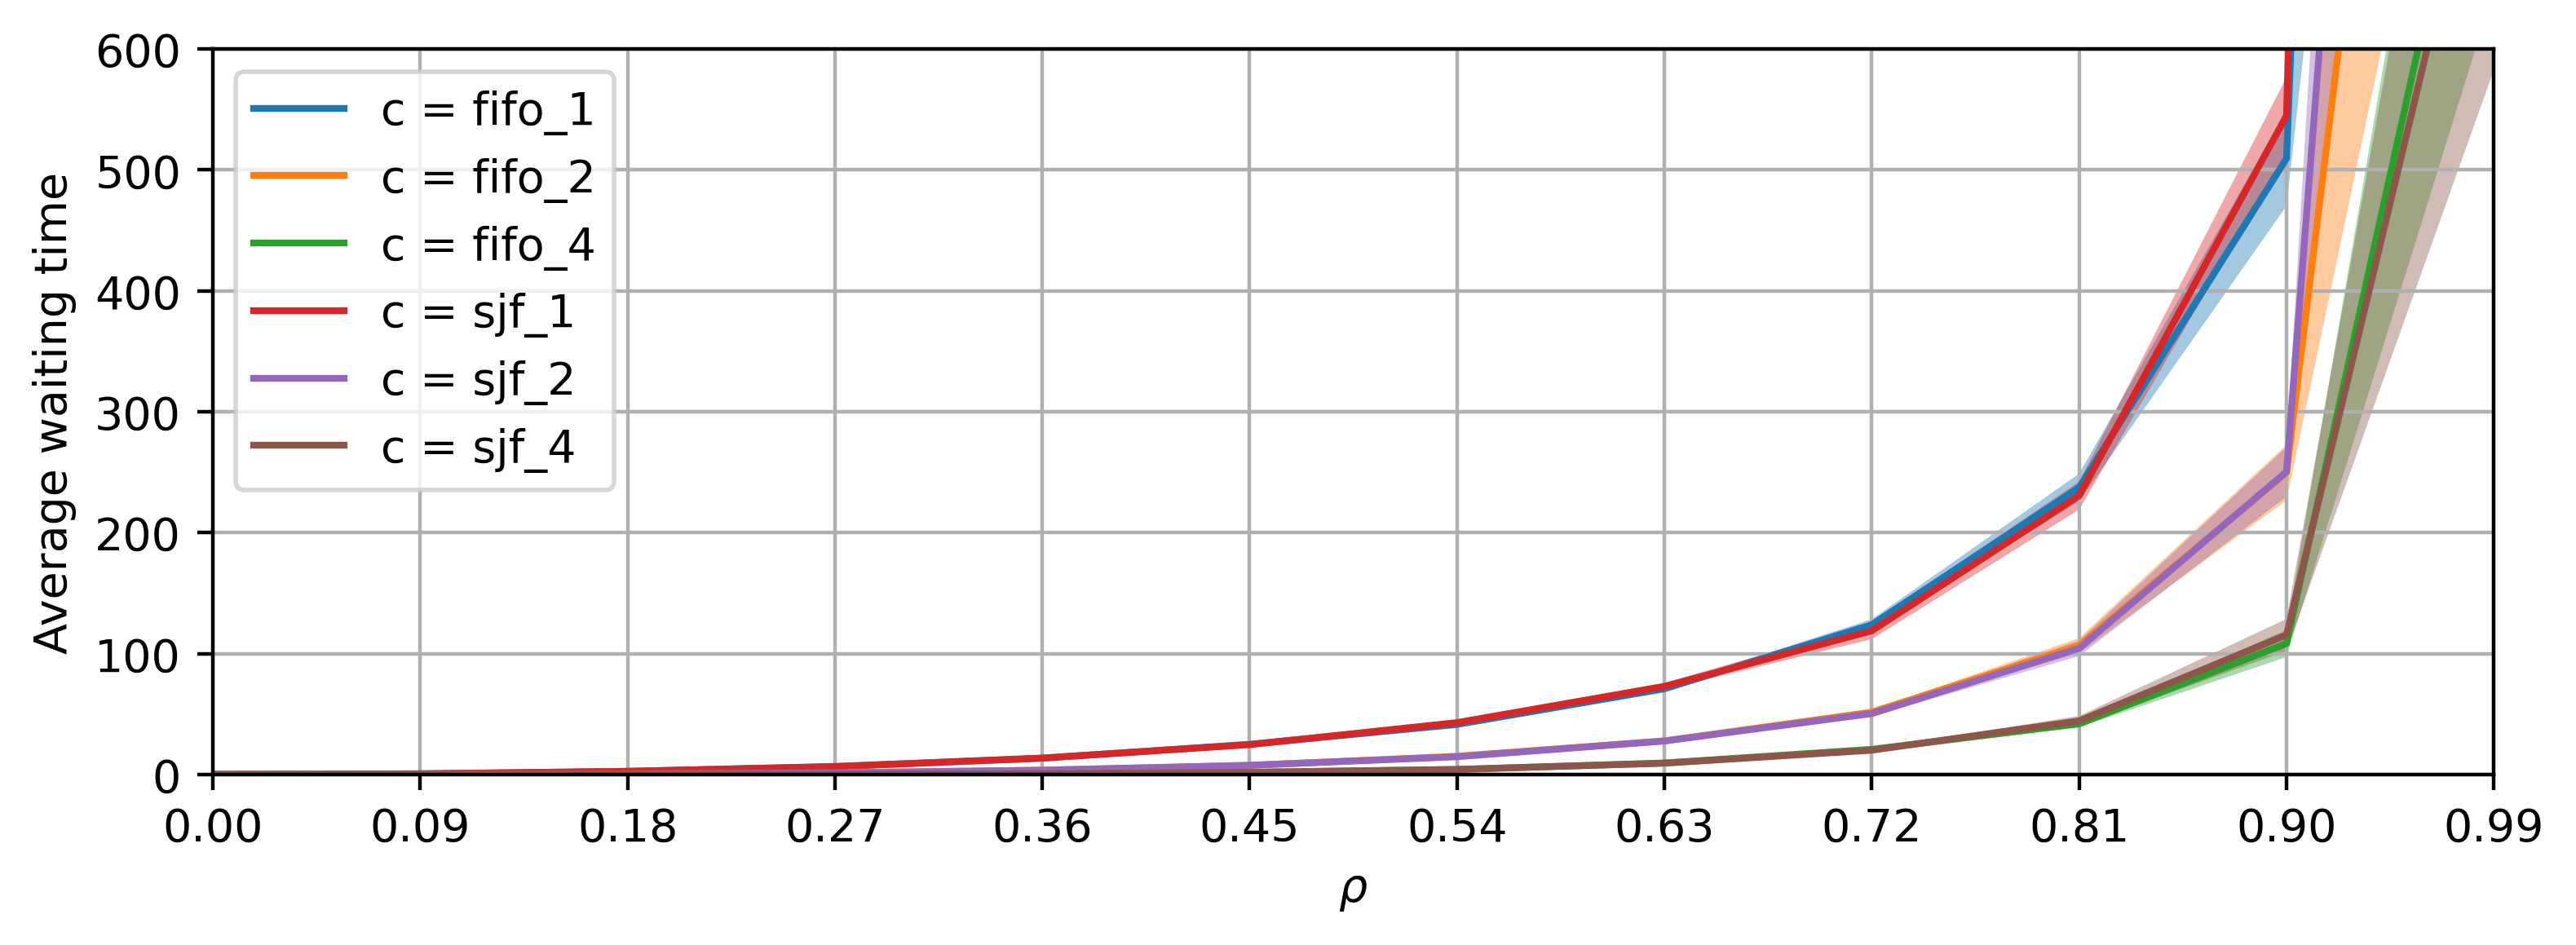

In [10]:
# Parameters
lambda_ = 0.015
N = 20_000
num_servers_list = [1, 2, 4]
scheduler = 'fifo'
mode = 'Markov'

# Generate array of values for mu
rho_min, rho_max = 0.0, 0.99
rhos_step = 0.09

rhos = np.linspace(rho_min, rho_max, 12)
mus = lambda_ / rhos

# Number of runs
n = 10

# FIFO data is already generated and can be reused
fifo_data = {'fifo_' + str(key): value for key, value in data.items()}

# Generate SJF data
scheduler = 'sjf'
sjf_data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
sjf_data = {'sjf_' + str(key): value for key, value in sjf_data.items()}

# Combine dictionaries
data_combined = {**fifo_data, **sjf_data}

# Set plotting parameters
xticks = rhos.tolist()
xlim = [rhos[0], rhos[-1]]
ylim = [0, 600]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 3), dpi=400)
plot_waitingtimes(data_combined, ax, xticks=xticks, xlim=xlim, ylim=ylim)

ax.grid(True)
fig.tight_layout()
fig.savefig('Q3.png')
plt.show()

In [12]:
# Hypothesis to test: Shortest job first has shorter average waiting time

# Step 1. Get the waiting times
for num_servers in num_servers_list:

    sjf_waiting_time = data_combined[f'sjf_{num_servers}']['waitingtimes']
    fifo_waiting_time = data_combined[f'fifo_{num_servers}']['waitingtimes']

    # Step 2. Test the null hypothesis (H0): that both samples come from same distribution
    # The T-test "is a test for the null hypothesis that 2 independent samples have identical average (expected) values"
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    # For more on tests, see https://www.youtube.com/watch?v=CIbJSX-biu0 

    # Define confidence level to pass the null hypothesis test
    confidence_p = 0.05

    # Check if our data has a significantly different variance (assuming so if greater to smaller variance is > 4:1)
    var_ratio = max(np.var(sjf_waiting_time), np.var(fifo_waiting_time)) / min(np.var(sjf_waiting_time), np.var(fifo_waiting_time))
    equal_var = var_ratio < 4

    # Perform the 2 sample t test
    t_test_2_samples = stats.ttest_ind(sjf_waiting_time, fifo_waiting_time, equal_var=equal_var)
    passed_null_hypothesis = confidence_p > t_test_2_samples.pvalue

    # Print results
    print(f'Waiting times for {num_servers} servers:')
    print(f'FJS: {sjf_waiting_time}')
    print(f'FIFO: {fifo_waiting_time} \n')

    print('Averages')
    print(f'FJS: {np.mean(sjf_waiting_time)}')
    print(f'FIFO: {np.mean(fifo_waiting_time)} \n')

    print(f'Confidence threshold: {confidence_p}')
    print(f'T-Test p value: {t_test_2_samples.pvalue}')
    print(f'2 Sample T test passed: {passed_null_hypothesis}')

Waiting times for 1 servers:
FJS: [0.0, 0.6021357399184831, 2.6539484733137204, 6.521700250286732, 13.608658574485435, 24.7032939318591, 42.91489548761912, 72.90938506047108, 118.81562922749838, 230.6314734306505, 544.8369355416553, 6731.775536396092]
FIFO: [0.0, 0.5897071293507141, 2.603466097224755, 6.664652201031551, 13.464777667549217, 24.98558319458795, 41.38529303392757, 70.8848712538002, 123.82997778730255, 237.3503620693911, 509.3982945406192, 4786.930340183482] 

Averages
FJS: 649.1644660094875
FIFO: 484.8406104298556 

Confidence threshold: 0.05
T-Test p value: 0.8113295523491553
2 Sample T test passed: False
Waiting times for 2 servers:
FJS: [0.0, 0.04861460552606395, 0.3932561776033504, 1.3786873057721136, 3.5750309919958667, 7.649918858175606, 14.660418292555823, 27.72106180147687, 50.35536937586425, 104.353486598766, 250.4212118003727, 2452.4139160080585]
FIFO: [0.0, 0.04758961691517036, 0.39190866087834253, 1.4365309091162473, 3.538296595548103, 7.501602102896575, 15.110

Therefore, we are Failing to Reject Null Hypothesis and thus have to conclude that shortest job first does not has shorter average waiting time

In [13]:
# parameters
lambda_ = 0.015
N = 1000
num_servers_list = [1, 2, 4]
scheduler = 'fifo'

# Generate array of values for mu
rho_min, rho_max = 0.01, 1
rhos_step = 0.01

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs is defined by std_min. Once the standard deviation is less than the std min the simulation stops. 
# Std_min is fixed and universal for all rhos, thus, higher rhos will have higher number of simulations to reach the same std_min
# Once each method is over it stores the data

std_min = 150
data_markov = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'Markov', std_min)
print("Done with markov")

data_longtail = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'long tail', std_min)
print("Done with long tail")

data_deter = generate_waitingtimes2(lambda_, mus, N, num_servers_list, scheduler, 'deter', std_min)
print("Done with deter")

Done with markov
Done with long tail
Done with deter


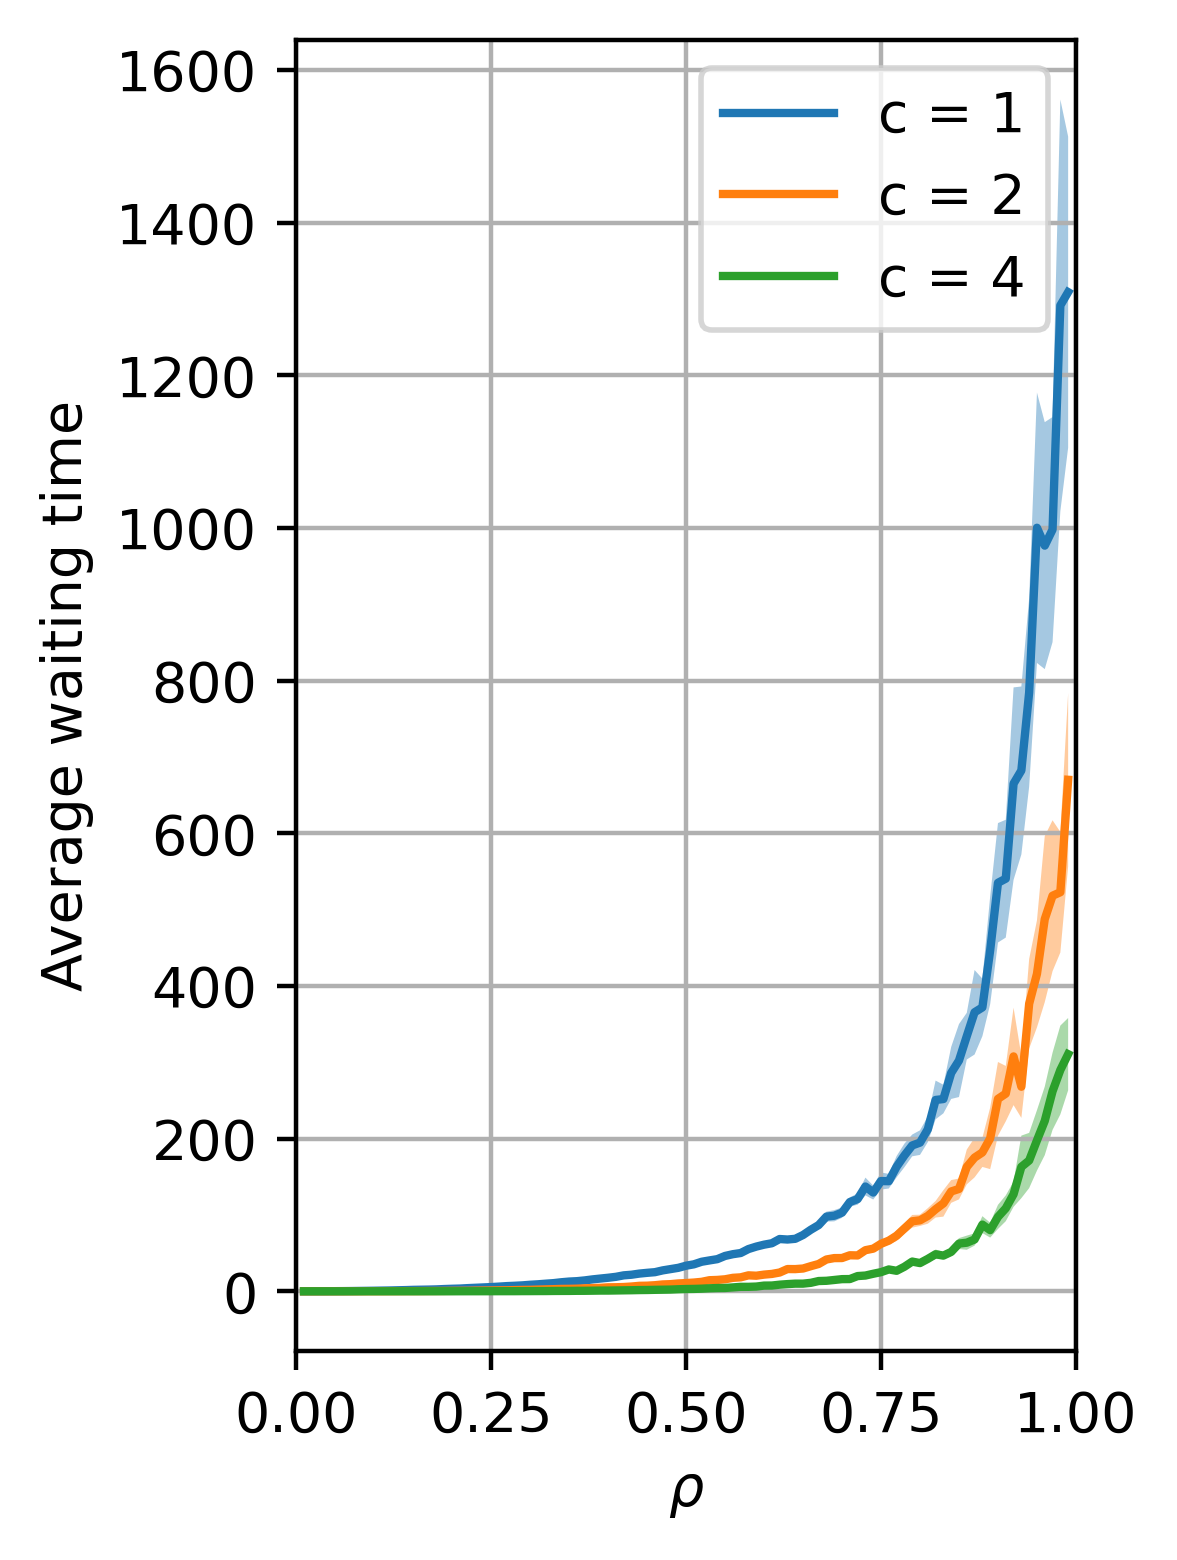

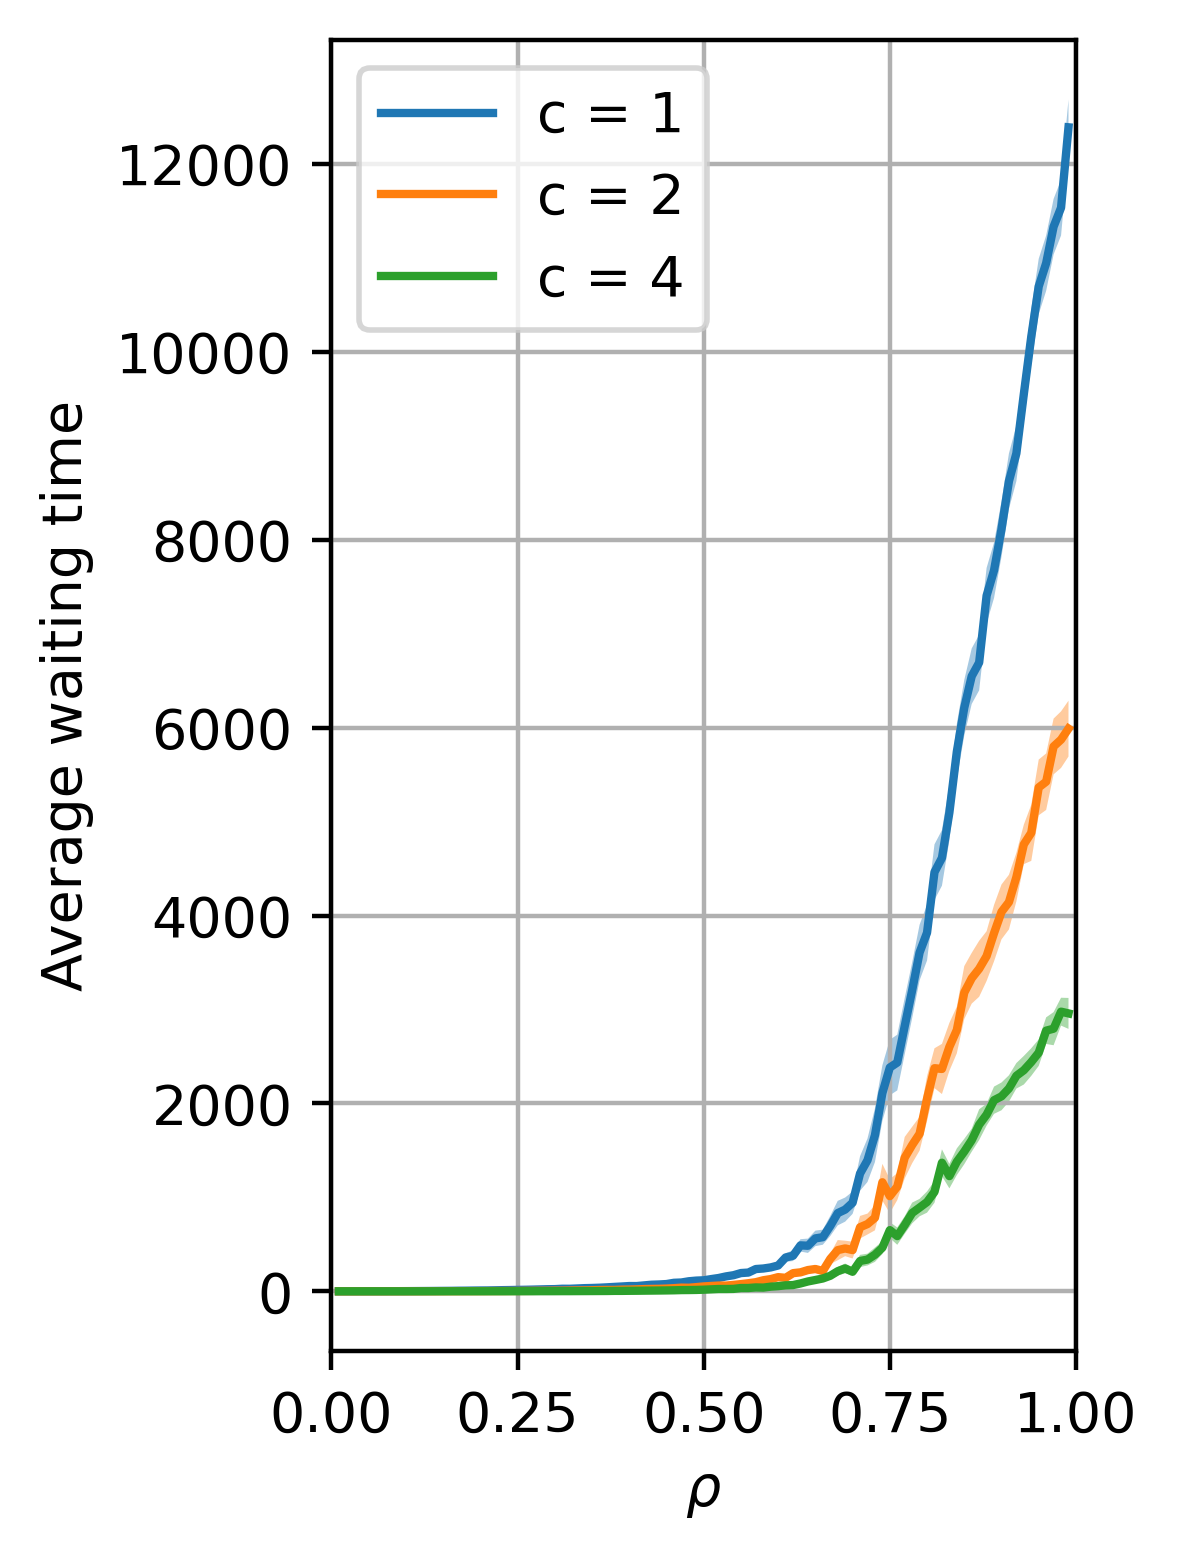

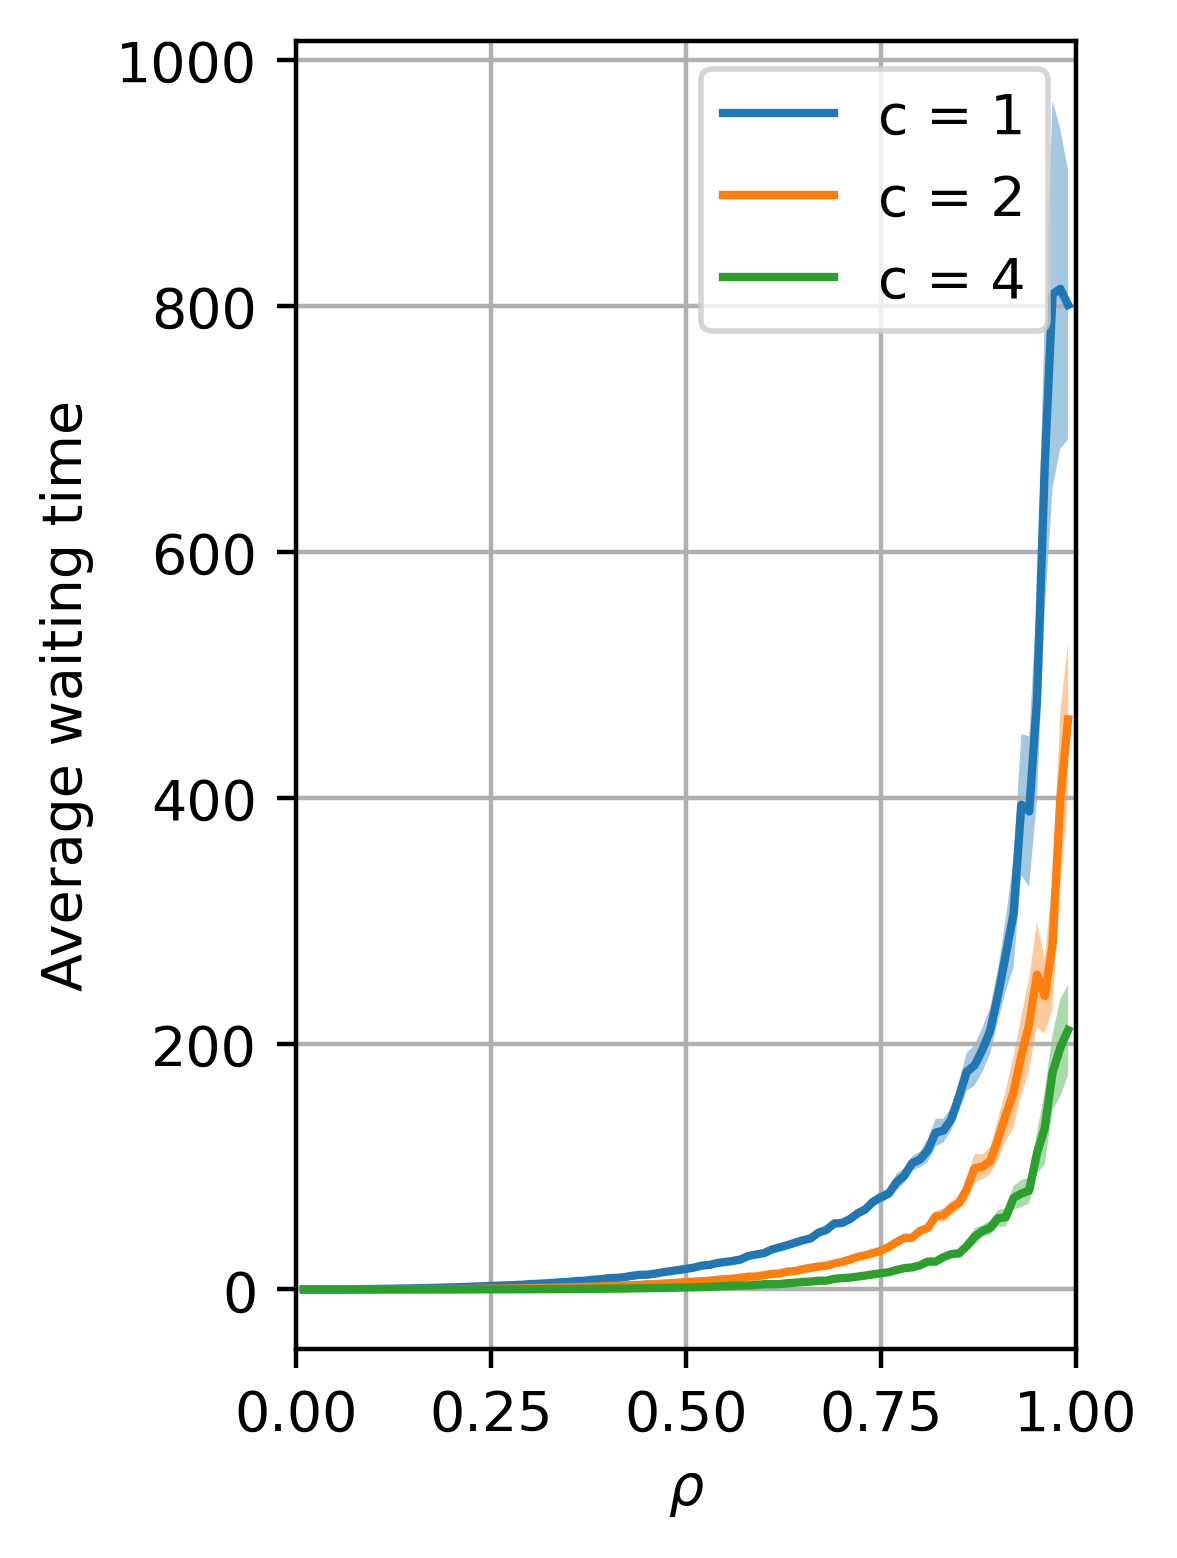

In [20]:
fig, ax = plt.subplots(figsize=(3, 4), dpi=400)

xlim = [0, 1]
plot_waitingtimes(data_markov, ax, xlim=xlim)
ax.grid(True)
fig.tight_layout()
fig.savefig('Q4_markov.png')

fig, ax = plt.subplots(figsize=(3, 4), dpi=400)
xlim = [0, 1]
plot_waitingtimes(data_longtail, ax, xlim=xlim)
ax.grid(True)
fig.tight_layout()
fig.savefig('Q4_tail.png')

fig, ax = plt.subplots(figsize=(3, 4), dpi=400)
xlim = [0, 1]
plot_waitingtimes(data_deter, ax, xlim=xlim)
ax.grid(True)
fig.tight_layout()
fig.savefig('Q4_deter.png')

In [21]:
print("For deterministic and markov")
welch_test(data_deter, data_markov)

print("\n For long tail and markov")
welch_test(data_longtail, data_markov)

print("\n For long tail and deter")
welch_test(data_deter, data_longtail)

For deterministic and markov
Number of servers is 1
Ttest_indResult(statistic=-2.045492612139386, pvalue=0.042418775012919595)
True
Number of servers is 2
Ttest_indResult(statistic=-1.8760807550064245, pvalue=0.06241814390016339)
False
Number of servers is 4
Ttest_indResult(statistic=-1.6680136588885988, pvalue=0.0972134517299306)
False

 For long tail and markov
Number of servers is 1
Ttest_indResult(statistic=5.249074452291004, pvalue=8.69354207698737e-07)
True
Number of servers is 2
Ttest_indResult(statistic=5.260404606536222, pvalue=8.302729285585307e-07)
True
Number of servers is 4
Ttest_indResult(statistic=5.275031630866495, pvalue=7.811527464335237e-07)
True

 For long tail and deter
Number of servers is 1
Ttest_indResult(statistic=-5.456774197738412, pvalue=3.618282062693834e-07)
True
Number of servers is 2
Ttest_indResult(statistic=-5.441283325214101, pvalue=3.8709934849101535e-07)
True
Number of servers is 4
Ttest_indResult(statistic=-5.431126779884538, pvalue=4.0461991232920

In [22]:
regression_test(data_deter, data_markov)

For 1 servers, we reject the null Hypothesis with a  slope of 1.602610814131899 and a pvalue of 5.304589362780426e-72
For 2 servers, we reject the null Hypothesis with a  slope of 1.5792692188375863 and a pvalue of 1.643271605667851e-76
For 4 servers, we reject the null Hypothesis with a  slope of 1.5826600278144065 and a pvalue of 4.1104858248495263e-88


In [23]:
regression_test(data_markov, data_longtail)

For 1 servers, we reject the null Hypothesis with a  slope of 11.639166244476165 and a pvalue of 3.102925630985519e-53
For 2 servers, we reject the null Hypothesis with a  slope of 12.273520424297313 and a pvalue of 1.675391044622742e-51
For 4 servers, we reject the null Hypothesis with a  slope of 12.462967452982628 and a pvalue of 9.380779129811257e-45


In [24]:
print("Correlation matrix")
correlation(data_markov, data_longtail, data_deter)

Correlation matrix
Correlation for 1 servers
             Markov  Long tail     Deter
Markov     1.000000   0.955514  0.981983
Long tail  0.955514   1.000000  0.916484
Deter      0.981983   0.916484  1.000000


Correlation for 2 servers
             Markov  Long tail     Deter
Markov     1.000000   0.951608  0.985480
Long tail  0.951608   1.000000  0.917377
Deter      0.985480   0.917377  1.000000


Correlation for 4 servers
             Markov  Long tail     Deter
Markov     1.000000   0.932708  0.991654
Long tail  0.932708   1.000000  0.898600
Deter      0.991654   0.898600  1.000000




In [25]:
deter = np.array(data_deter[1]["waitingtimes"])
markov = np.array(data_markov[1]["waitingtimes"])
longtail = np.array(data_longtail[1]["waitingtimes"])

print(np.mean(longtail / deter))
print(np.mean(markov / deter))

13.886576135645024
1.9661297320968285
